# Analysis of MPI Matrix Multiplication Performance

This notebook analyzes the performance data generated by the `batch_executor.py` script. The goal is to compare four different MPI communication strategies:

1.  **collective**: Using high-level blocking collectives (`MPI_Scatter`, `MPI_Gather`).
2.  **sync**: Using blocking point-to-point communication (`MPI_Send`, `MPI_Recv`).
3.  **async_naive**: A non-blocking implementation with an immediate `MPI_Wait`, simulating blocking behavior.
4.  **async**: An improved non-blocking implementation aiming to overlap communication.

We will generate several plots to visualize performance, scalability, and overhead.

In [1]:
# Cell 1: Setup and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid", palette="viridis")

try:
    file_name = '../report/central.csv'
    df = pd.read_csv(file_name)
    
    df['total_time_mean'] = pd.to_numeric(df['total_time_mean'])
    df['comm_time_mean'] = pd.to_numeric(df['comm_time_mean'])
    df['comp_time_mean'] = pd.to_numeric(df['comp_time_mean'])
    df['total_time_std'] = pd.to_numeric(df['total_time_std'])

    print("Data loaded and preprocessed successfully!")
    df.head()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    print("Please make sure the CSV file is in the correct directory and the filename is correct.")
    df = pd.DataFrame()

Data loaded and preprocessed successfully!


## Chart 1 - Performance by Communication Type (Grouped Bar Chart)
This chart directly compares the total runtime of each method for different process counts, providing a clear view of the fastest approach in each scenario.

<Figure size 1400x800 with 0 Axes>

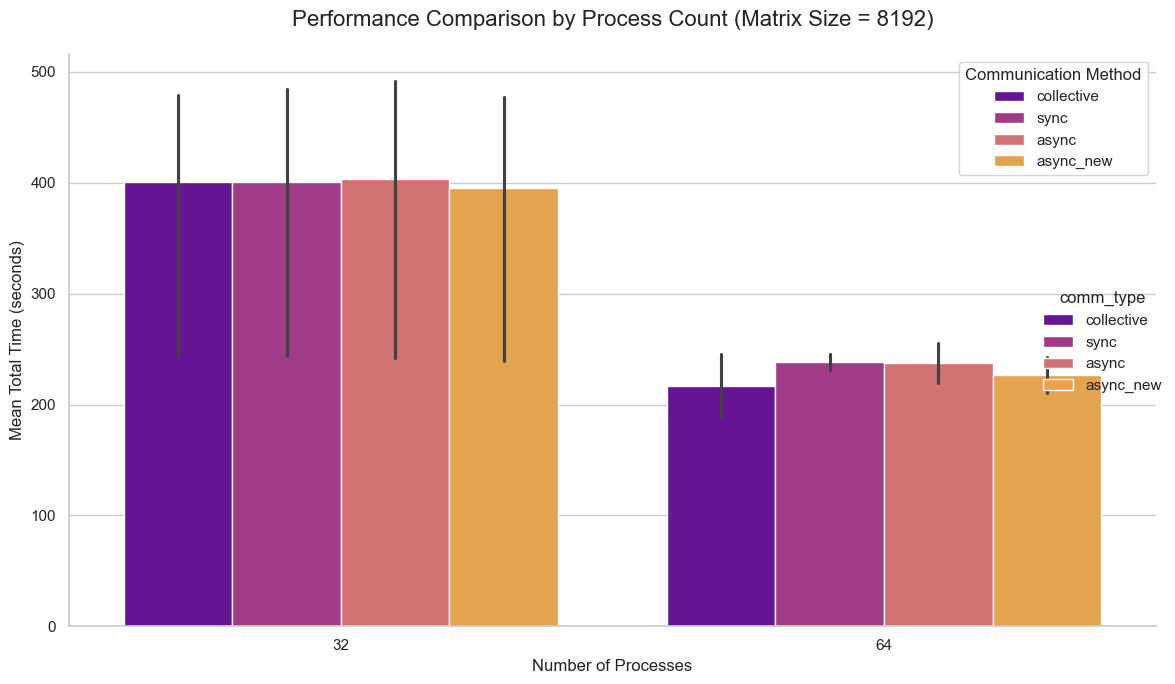

In [ ]:
if not df.empty:
    plt.figure(figsize=(14, 8))
    
    sns.catplot(
        data=df,
        x='num_procs',
        y='total_time_mean',
        hue='comm_type',
        kind='bar',
        height=7,
        aspect=1.5,
        palette='plasma',
    )

    
    plt.title('Performance Comparison by Process Count (Matrix Size = 8192)', fontsize=16, pad=20)
    plt.xlabel('Number of Processes', fontsize=12)
    plt.ylabel('Mean Total Time (seconds)', fontsize=12)
    plt.legend(title='Communication Method', loc='upper right')
    plt.tight_layout()
    plt.show()

## Chart 2 - Impact of Node Distribution on Performance
This chart is crucial for an HPC context. It shows how performance is affected when the same number of processes are spread across a different number of physical nodes, highlighting communication overhead.

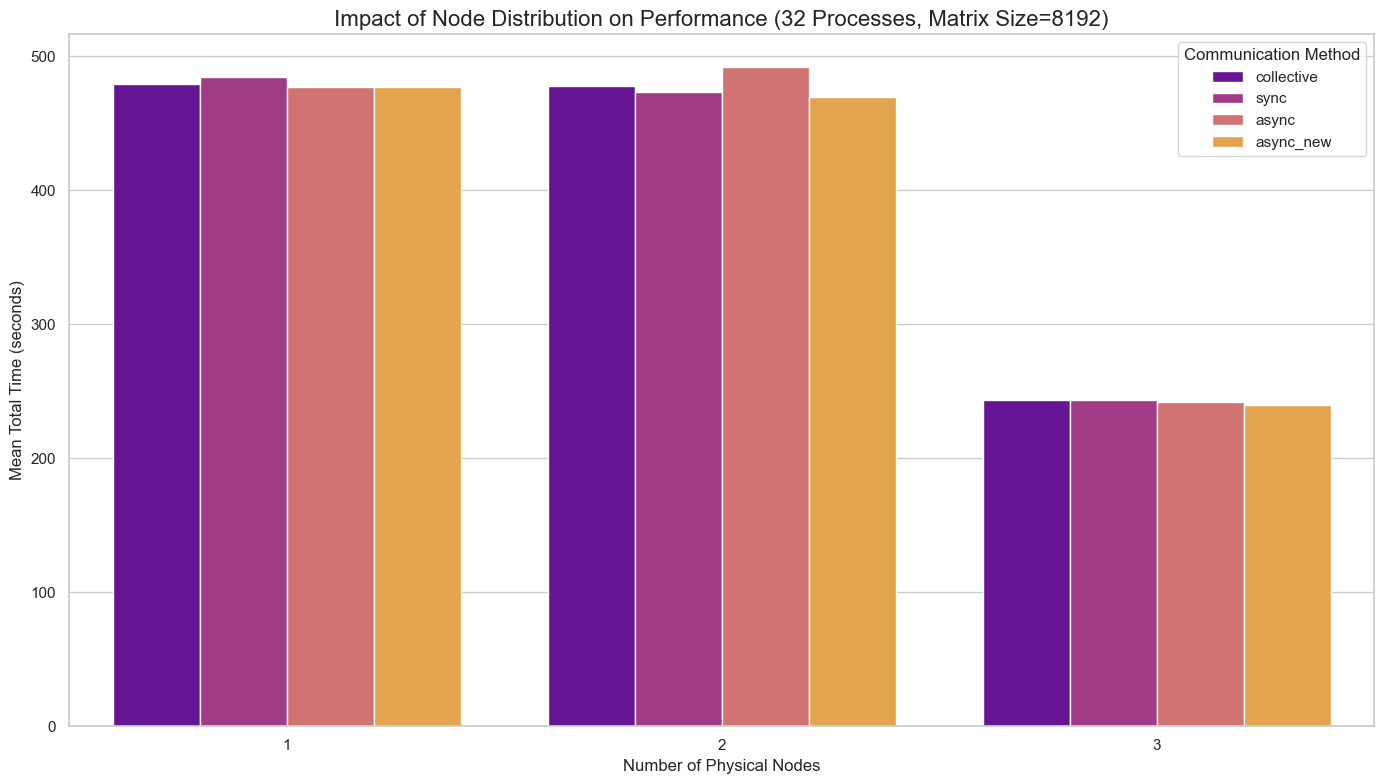

In [9]:
if not df.empty:
    # Filter data for a fixed number of processes to see the effect of node distribution
    df_filtered = df[df['num_procs'] == 32]
    
    plt.figure(figsize=(14, 8))
    
    sns.barplot(
        data=df_filtered,
        x='nodes',
        y='total_time_mean',
        hue='comm_type',
        palette='plasma'
    )
    
    plt.title('Impact of Node Distribution on Performance (32 Processes, Matrix Size=8192)', fontsize=16)
    plt.xlabel('Number of Physical Nodes', fontsize=12)
    plt.ylabel('Mean Total Time (seconds)', fontsize=12)
    plt.legend(title='Communication Method')
    plt.tight_layout()
    plt.show()

## Chart 3 - Time Breakdown (Communication vs. Computation)
This stacked bar chart explains why certain methods are faster by visualizing the proportion of time spent on communication versus actual computation.

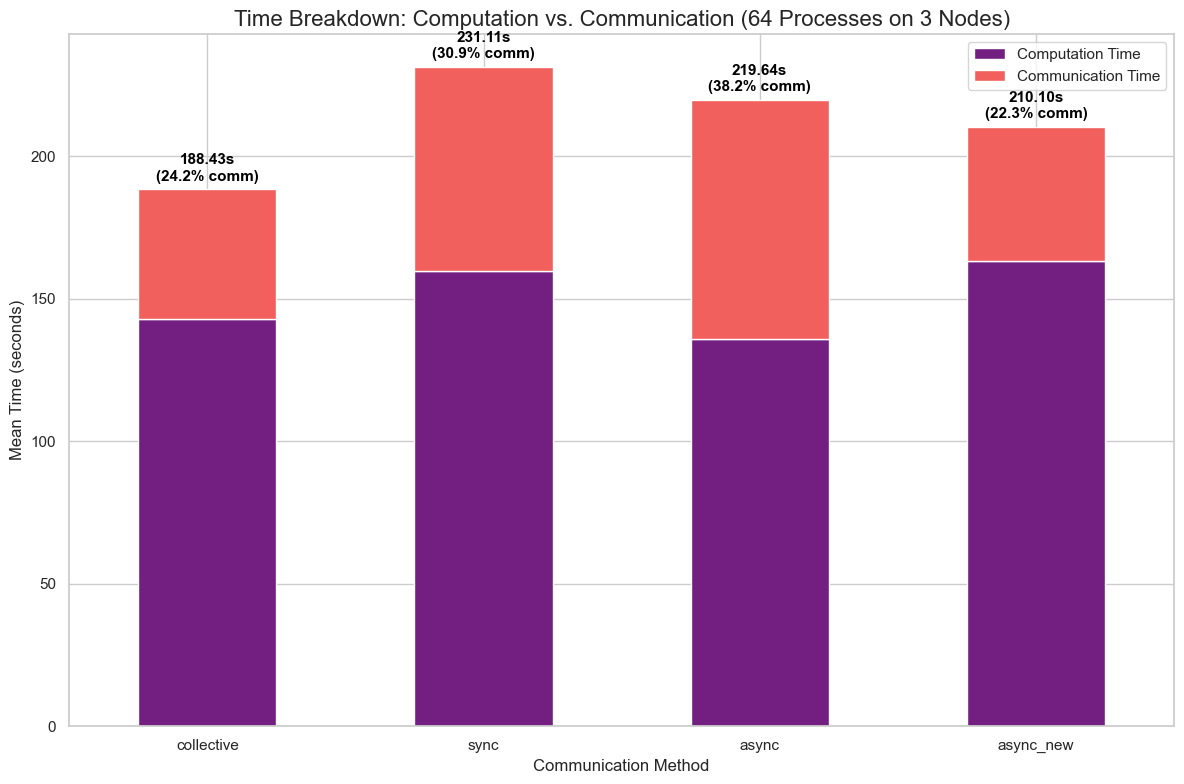

In [6]:
# Cell 4: Chart 3 - Time Breakdown

if not df.empty:
    # Select a representative high-load scenario for the breakdown
    # Here, we choose 64 processes on 3 nodes
    df_breakdown = df[(df['num_procs'] == 64) & (df['nodes'] == 3)].copy()

    if df_breakdown.empty:
        print("Data for the breakdown chart scenario (64 procs, 3 nodes) not found.")
    else:
        # Set the communication type as the index for easier plotting
        df_breakdown.set_index('comm_type', inplace=True)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot the stacked bars
        df_breakdown[['comp_time_mean', 'comm_time_mean']].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=sns.color_palette("magma", 2)
        )
        
        # Add labels on top of each bar and percentage of communication time
        for idx, row in df_breakdown.iterrows():
            total_height = row['total_time_mean']
            comm_pct = 100 * row['comm_time_mean'] / total_height if total_height > 0 else 0
            ax.text(
                ax.get_xticks()[df_breakdown.index.get_loc(idx)],
                total_height * 1.01,
                f'{total_height:.2f}s\n({comm_pct:.1f}% comm)',
                ha='center', va='bottom', fontsize=11, weight='bold', color='black'
            )

        plt.title('Time Breakdown: Computation vs. Communication (64 Processes on 3 Nodes)', fontsize=16)
        plt.xlabel('Communication Method', fontsize=12)
        plt.ylabel('Mean Time (seconds)', fontsize=12)
        plt.xticks(rotation=0) # Keep x-axis labels horizontal
        plt.legend(['Computation Time', 'Communication Time'])
        plt.tight_layout()
        plt.show()

## Chart 4 - Strong Scaling and Speedup
This final set of plots evaluates how well the methods scale. Since your data has only two process counts (32 and 64), the charts will show a simple two-point trend, which is still very illustrative.

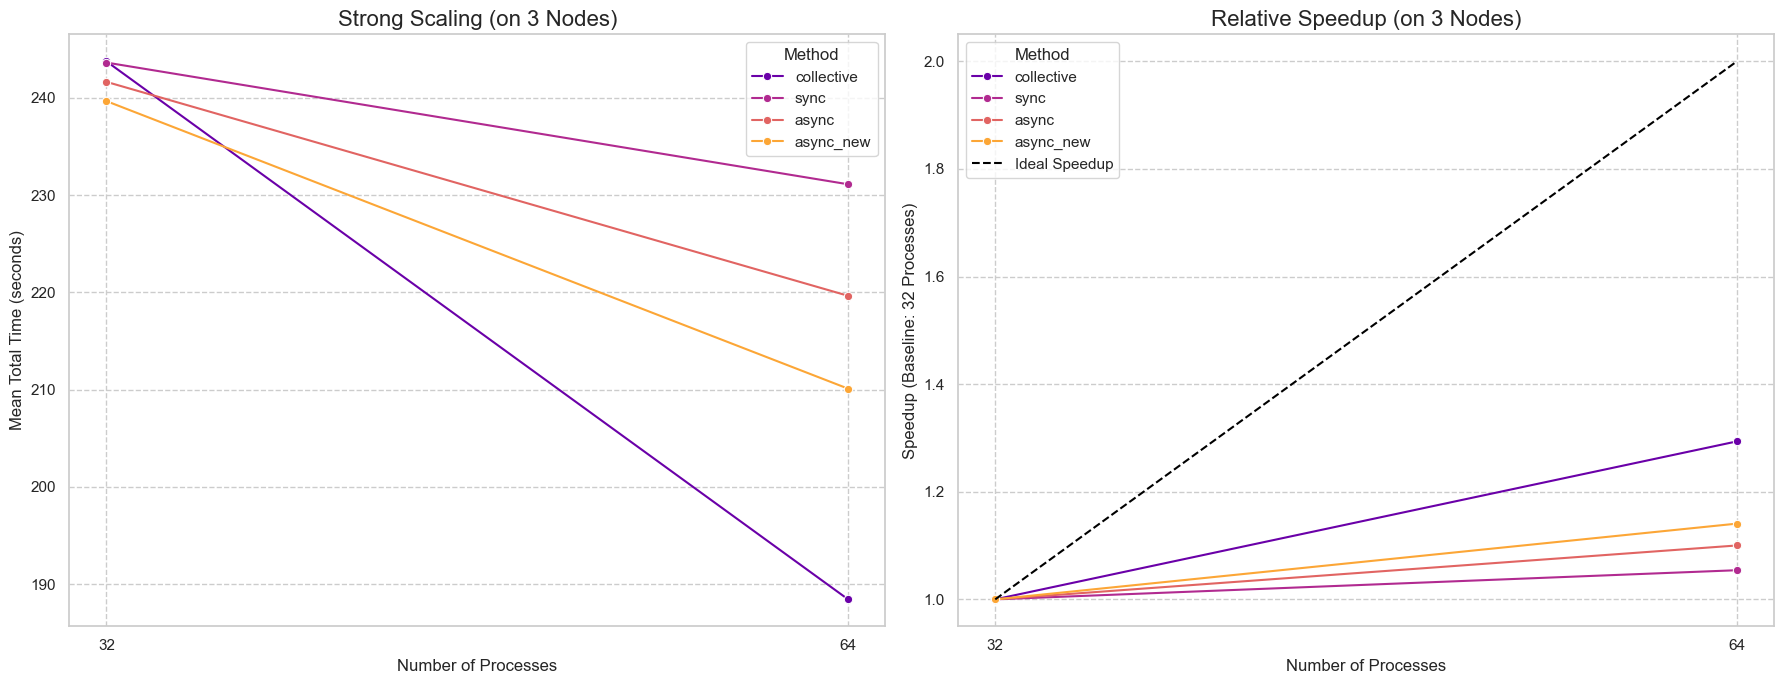

In [5]:
# Cell 5: Chart 4 - Strong Scaling and Speedup

if not df.empty:
    # We will analyze scaling on the 3-node runs, which is often a realistic scenario
    df_scaling = df[df['nodes'] == 3].copy()
    
    if df_scaling.empty:
        print("Data for scaling analysis (3-node runs) not found.")
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # --- Part A: Strong Scaling Plot ---
        sns.lineplot(data=df_scaling, x='num_procs', y='total_time_mean', hue='comm_type', marker='o', ax=ax1, palette='plasma')
        ax1.set_title('Strong Scaling (on 3 Nodes)', fontsize=16)
        ax1.set_xlabel('Number of Processes', fontsize=12)
        ax1.set_ylabel('Mean Total Time (seconds)', fontsize=12)
        ax1.set_xticks(df_scaling['num_procs'].unique())
        ax1.legend(title='Method')
        ax1.grid(True, which="both", ls="--")

        # --- Part B: Speedup Plot ---
        baseline_procs = df_scaling['num_procs'].min()
        
        # Get baseline times for each method
        baseline_times = df_scaling[df_scaling['num_procs'] == baseline_procs].set_index('comm_type')['total_time_mean']
        
        # Calculate speedup
        df_scaling['speedup'] = df_scaling.apply(
            lambda row: baseline_times[row['comm_type']] / row['total_time_mean'],
            axis=1
        )
        
        sns.lineplot(data=df_scaling, x='num_procs', y='speedup', hue='comm_type', marker='o', ax=ax2, palette='plasma')

        # Plot ideal speedup line
        procs = sorted(df_scaling['num_procs'].unique())
        ideal_speedup = [p / baseline_procs for p in procs]
        ax2.plot(procs, ideal_speedup, linestyle='--', color='black', label='Ideal Speedup')
        
        ax2.set_title('Relative Speedup (on 3 Nodes)', fontsize=16)
        ax2.set_xlabel('Number of Processes', fontsize=12)
        ax2.set_ylabel(f'Speedup (Baseline: {baseline_procs} Processes)', fontsize=12)
        ax2.set_xticks(procs)
        ax2.legend(title='Method')
        ax2.grid(True, which="both", ls="--")
        
        plt.tight_layout()
        plt.show()